In [1]:
from atl_module import icesat_bathymetry
from atl_module import kriging
from atl_module import kalman
from atl_module.geospatial_functions import to_refr_corrected_gdf
from atl_module import error_calc
import geopandas as gpd
import contextily as cx
import xyzservices.providers as xyz
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show as rastershow
import cartopy
from importlib import reload 
import pandas as pd

# Kalman Updating of GEBCO via ICESat-2 data

This notebook walks through the full process, from raw ATL03 granules to the error checking.

To run this notebook, the data for the test site is downloaded . The data downloaded will consists of granules that are subset just to our spatial AOI. Each granule contains a single satellite pass of the area, and it contains up to 6 beams. These granules will will contain all photon returns, including those with significant noise. They will also include returns from the ground, tree canopies, and the ocean surface. 

## Study site
The study site chosen to test the methods initially was an area of the Florida Keys, an archipelago in Florida, USA. 
### ICESat-2 data at the study site
The study site, along with the tracklines of the ICESat-2 tracks, as shown below:

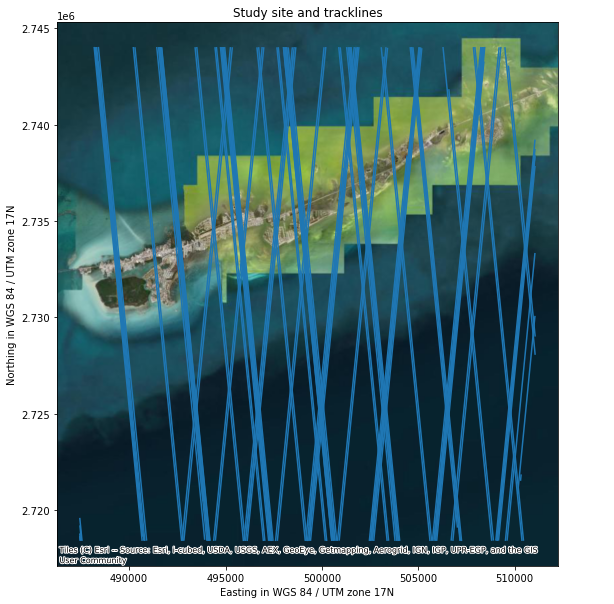

In [4]:
tracklines = gpd.read_file('../data/test_sites/florida_keys/atl03_tracks.gpkg',)
ax = tracklines.plot(figsize=(20,10))
cx.add_basemap(ax,source=cx.providers.Esri.WorldImagery,crs=tracklines.crs)
ax.set_xlabel(f'Easting in {tracklines.crs.name}')
ax.set_ylabel(f'Northing in {tracklines.crs.name}')
ax.set_title('Study site and tracklines')
ax.get_figure().savefig('../document/figures/study_site_tracklines.jpg',dpi=300,facecolor='white',bbox_inches='tight')

### Test data used for Comparison

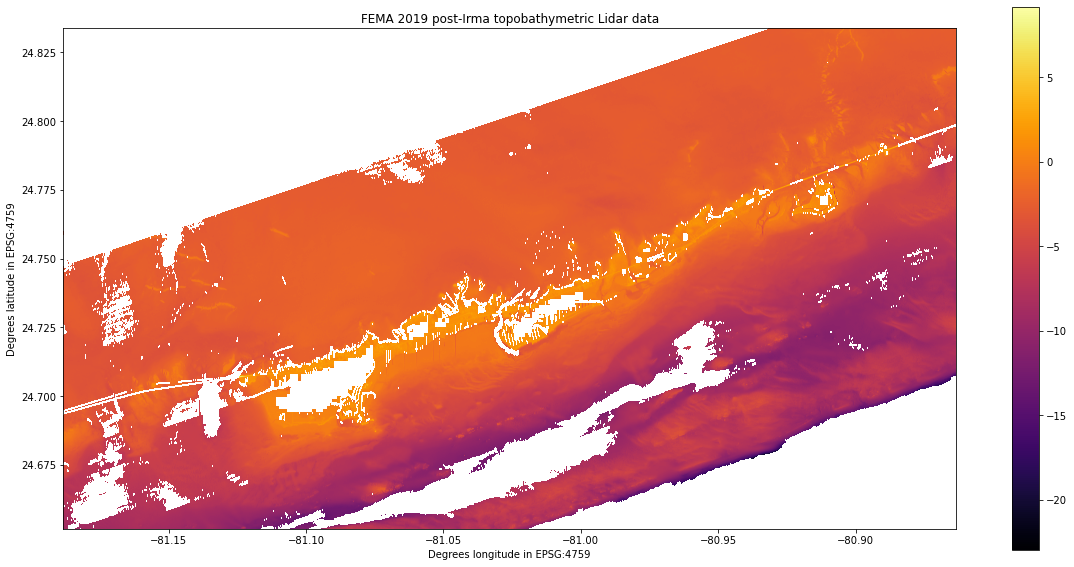

In [5]:
# TODO add basemap, currently causing a bug
with rasterio.open('../data/test_sites/florida_keys/in-situ-DEM/2019_irma.vrt') as femaras:
    fig, ax = plt.subplots(figsize=(20,10))
    ax.set_xlabel(f'Degrees longitude in {femaras.crs}')
    ax.set_ylabel(f'Degrees latitude in {femaras.crs}')
    ax.set_title('FEMA 2019 post-Irma topobathymetric Lidar data')
    # cx.add_basemap(ax,source=cx.providers.OpenTopoMap,crs=femaras.crs)
    image_hidden = ax.imshow(femaras.read(1,masked=True), 
                         cmap='inferno',)
    rastershow(femaras,cmap='inferno',ax=ax)
    

    fig.colorbar(image_hidden,ax=ax)

In [ ]:
fig.savefig('../document/figures/florida_keys_ras.jpg',dpi=800,facecolor='white',bbox_inches='tight')

## Step 1: Scan all beams in all granules for bathymetry points

### Run KDE function
The function below runs the KDE algorithm, and plots the resulting points

In [2]:
site_path = '../data/test_sites/florida_keys/'

In [2]:
bathy_pts = icesat_bathymetry.bathy_from_all_tracks_parallel(
    site_path,
    window=200,
    threshold_val=0.0,
    req_perc_hconf=65,
)

NameError: name 'icesat_bathymetry' is not defined

In [7]:
gdf = to_refr_corrected_gdf(bathy_pts, crs="EPSG:32752")
gdf.to_file(site_path + "/all_bathy_pts.gpkg", overwrite=True)


In [7]:
gdf = gpd.read_file(site_path + "/all_bathy_pts.gpkg")
gdf = error_calc.add_true_elevation(gdf,'../data/test_sites/florida_keys/in-situ-DEM/2019_irma.vrt')

### Results

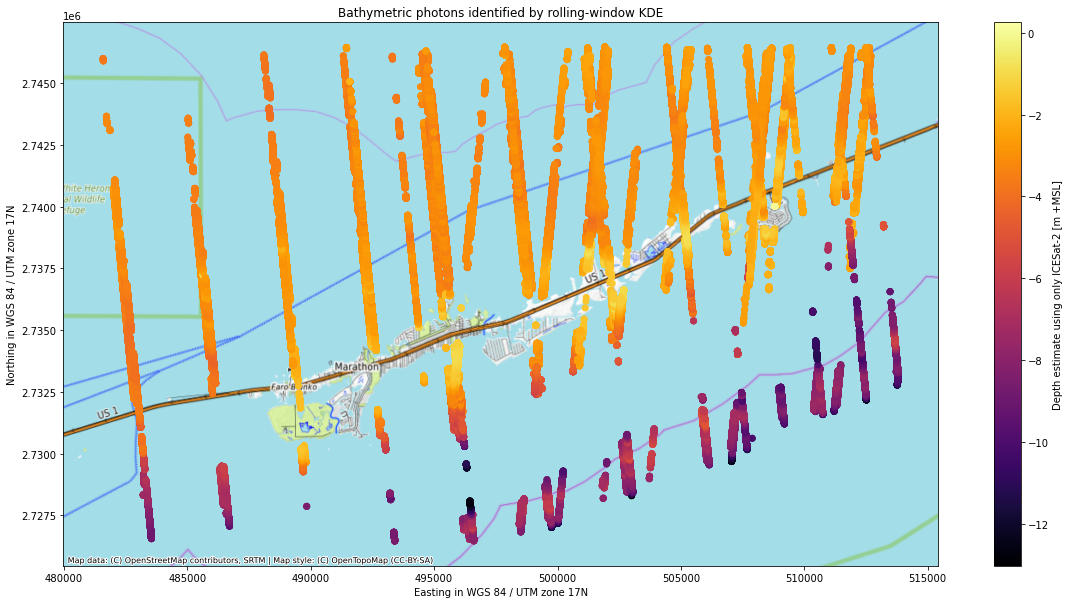

In [19]:
ax = gdf.plot(figsize=(20,10),column='z_kde',cmap='inferno',legend=True,legend_kwds={'label':'Depth estimate using only ICESat-2 [m +MSL]'})
cx.add_basemap(ax,source=cx.providers.OpenTopoMap,crs=gdf.crs)

ax.set_xlabel(f'Easting in {gdf.crs.name}')
ax.set_ylabel(f'Northing in {gdf.crs.name}')
ax.set_title('Bathymetric photons identified by rolling-window KDE')
ax.get_figure().savefig('../document/figures/florida_test_site_photon_map.jpg',dpi=400,bbox_inches='tight',facecolor='white')

### Error between Lidar Data and Test data

To test the accuracy of the algorithm that extracts signal from the ICESat-2 Granule, the Root mean sqaure error (RMSE) and the Mean average Error (MAE)

In [9]:
overall_rmse = error_calc.calc_rms_error(gdf,['true_elevation'])['true_elevation_error']
print(f'RMS error between photons and ground truth data is {overall_rmse}')

RMS error between photons and ground truth data is 119.0520173726112


In [10]:
# find a way to group by unique track ID
error_by_type = gdf.groupby('beamtype').apply(lambda x:error_calc.calc_rms_error(x,['true_elevation'])['true_elevation_error']**(0.5))
error_by_atmostpheric_profile = gdf.groupby('atm_profile').apply(lambda x:error_calc.calc_rms_error(x,['true_elevation'])['true_elevation_error']**(0.5))

In [11]:
pd.DataFrame.from_dict({'RMS error':error_by_type}).style.to_latex(buf='../document/tables/rms_by_type.tex',caption='Beam Strength vs Error')
pd.DataFrame.from_dict({'RMS Error':error_by_atmostpheric_profile}).style.to_latex(buf='../document/tables/rms_by_atm.tex',caption='Atmospheric Profile vs error')

## Step 2: Interpolate the resulting points using geostatistics

In [ ]:
kriging.krige_bathy(krmodel=kriging.UniversalKriging,
        initial_raster_path=f'{site_path}/bilinear.tif',
        pointfolder_path=site_path,
        npts=2000,
        variogram_model='spherical',
        outraster_path=f'{site_path}/kriged.tif')

2000 points remaining after relaxation dart throwing culling
2000 Points written to output LAZ and geopackage files
Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'linear' Variogram Model
Slope: 1.2968371454620253e-16
Nugget: 0.5686087457341255 

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



## Step 3: Run the Kalman updating 

In [16]:
kalman.gridded_kalman_update("../data/test_sites/florida_keys/kalman_updated.tif",
        "../data/test_sites/florida_keys/bilinear.tif",
        "../data/test_sites/florida_keys/kriging_output.tif",
        1
    )

Wrote Kalman Updated Raster


## Step 4: Find error

In [17]:
rmse_error_kalman = error_calc.raster_RMSE("../data/test_sites/florida_keys/in-situ-DEM/2019_irma.vrt",
        "../data/test_sites/florida_keys/kalman_updated.tif",)


In [ ]:
rmse_error_naive = error_calc.raster_RMSE("../data/test_sites/florida_keys/in-situ-DEM/2019_irma.vrt",
        "../data/test_sites/florida_keys/bilinear.tif",)

In [18]:
raster_summary = pd.DataFrame.from_dict({'Naive Bilinear Interpolation':rmse_error_naive,'Kalman Updated Raster':rmse_error_kalman},orient='index')
raster_summary

,RMSE,MAE
Naive Bilinear Interpolation,2.086102,0.986900
Kalman Updated Raster,1.345899,0.836557


In [19]:
raster_summary.style.to_latex(buf='../document/tables/total_raster_error_kalman_vs_bi.tex',label='raster_rmse_comparison',position='h!',hrules=True,caption='Comparison of the error metrics between the Kalman updating and a simple bilinear interpolaton of GEBCO data')